# Treinamento Classificação de Idade Óssea (anos)
Notebook adaptado para imagens binárias e classificação discreta em anos.
- CSV contém colunas: `id`, `boneage`
- Ignora coluna `male`
- Relatórios finais: Classification Report + Matriz de Confusão

In [ ]:
# =========================================================
# Treinamento Regressão de Idade Óssea (meses)
# =========================================================

!pip install timm albumentations pandas scikit-learn matplotlib seaborn tqdm torch torchvision

from google.colab import drive
drive.mount('/content/drive')

In [2]:
# =========================================================
# Descompactar zip
# =========================================================
!unzip /content/b380x380.zip -d /content/saida

Mounted at /content/drive


In [28]:
# =========================================================
# Imports
# =========================================================
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [29]:
# =========================================================
# Device
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

Usando device: cuda


In [41]:
# =========================================================
# Dataset
# =========================================================
class BoneAgeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['id']}.png")
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # grayscale
        if image is None:
            raise FileNotFoundError(f"Imagem não encontrada: {img_path}")
        #image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # para compatibilidade com albumentations

        if self.transform:
            image = self.transform(image=image)["image"]

        target = row["boneage"]  # em meses
        return image, target

In [ ]:
# =========================================================
# Carregar CSV (boneage em MESES)
# =========================================================
csv_path = "/content/drive/MyDrive/TCC/male_training.csv"
img_dir = "/content/saida/male_380x380"

df = pd.read_csv(csv_path)
df['boneage'] = df['boneage'].astype(float)

print(df.head())
print("Idade mínima (meses):", df['boneage'].min())
print("Idade máxima (meses):", df['boneage'].max())

     id  boneage   male
0  1377    180.0  False
1  1378     12.0  False
2  1379     94.0  False
3  1381     82.0  False
4  1388    126.0  False
Idade mínima (meses): 4.0
Idade máxima (meses): 216.0


In [44]:
# =========================================================
# Split estratificado por FAIXAS (anos)
# =========================================================
df['_strata_year'] = (df['boneage'] // 12).clip(0, 18).astype(int)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['_strata_year'],
    random_state=42
)

train_df = train_df.drop(columns=['_strata_year'])
val_df   = val_df.drop(columns=['_strata_year'])

In [45]:
# =========================================================
# Transforms
# =========================================================
train_tfms = A.Compose([
    A.Resize(380, 380),
    A.HorizontalFlip(p=0.5),
    A.Affine(scale=(0.95, 1.05), translate_percent=(0.02, 0.02), rotate=(-10, 10), p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.CLAHE(clip_limit=2.0, p=0.3),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])
val_tfms = A.Compose([
    A.Resize(380, 380),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

train_ds = BoneAgeDataset(train_df, img_dir, transform=train_tfms)
val_ds   = BoneAgeDataset(val_df,   img_dir, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

/tmp/ipython-input-2674952367.py:10: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),


In [51]:
# =========================================================
# Modelo EfficientNet-B4 (regressão)
# =========================================================
backbone = timm.create_model('efficientnet_b4', pretrained=True, num_classes=0, in_chans=1)

for p in backbone.parameters():
    p.requires_grad = False
for p in backbone.blocks[-1].parameters():
    p.requires_grad = True

in_features = backbone.num_features
reg_head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features, 1)
)
model = nn.Sequential(backbone, reg_head).to(device)

In [52]:
# =========================================================
# Loss / Otimizador / Scheduler
# =========================================================
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 50
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS
)

scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-3118302326.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [53]:
# =========================================================
# Funções de treino/val
# =========================================================
def train_one_epoch(model, loader, optimizer, criterion, device, epoch):
    model.train()
    total_loss, total_mae, total = 0, 0, 0
    loop = tqdm(loader, total=len(loader), leave=False)
    for imgs, targets in loop:
        imgs = imgs.to(device)
        targets = torch.as_tensor(targets, dtype=torch.float32, device=device).unsqueeze(1)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item() * imgs.size(0)
        total_mae  += torch.abs(outputs - targets).sum().item()
        total      += imgs.size(0)

        loop.set_description(f"Epoch {epoch+1}/{EPOCHS}")
        loop.set_postfix(loss=loss.item(), mae=total_mae/total)
    return total_loss/total, total_mae/total

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, total_mae, total = 0, 0, 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = imgs.to(device)
            targets = torch.as_tensor(targets, dtype=torch.float32, device=device).unsqueeze(1)
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                loss = criterion(outputs, targets)

            total_loss += loss.item() * imgs.size(0)
            total_mae  += torch.abs(outputs - targets).sum().item()
            total      += imgs.size(0)
    return total_loss/total, total_mae/total



In [54]:
# =========================================================
# Treinamento
# =========================================================
best_val_mae = float("inf")
patience = 10
epochs_no_improve = 0

for epoch in range(EPOCHS):
    train_loss, train_mae = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
    val_loss,   val_mae   = validate(model, val_loader, criterion, device)

    print(f"\nEpoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f}, MAE: {train_mae:.2f} | "
          f"Val Loss: {val_loss:.4f}, MAE: {val_mae:.2f}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), "/content/best_model_regression.pth")
        print(">> Modelo salvo!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f">> Val MAE não melhorou ({epochs_no_improve}/{patience})")

    if epochs_no_improve >= patience:
        print(">> Early stopping: MAE não melhora há", patience, "épocas.")
        break

    if epoch == 15:
        for p in backbone.parameters():
            p.requires_grad = True
        print(">> Todas as camadas liberadas para fine-tuning")


  0%|          | 0/145 [00:00<?, ?it/s]/tmp/ipython-input-3695160076.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/tmp/ipython-input-3695160076.py:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



Epoch 1/50 | Train Loss: 117.2238, MAE: 117.22 | Val Loss: 115.1505, MAE: 115.15
>> Modelo salvo!



Epoch 2/50 | Train Loss: 97.7098, MAE: 97.71 | Val Loss: 49.9051, MAE: 49.91
>> Modelo salvo!



Epoch 3/50 | Train Loss: 37.1486, MAE: 37.15 | Val Loss: 16.0710, MAE: 16.07
>> Modelo salvo!



Epoch 4/50 | Train Loss: 20.9205, MAE: 20.92 | Val Loss: 13.9852, MAE: 13.99
>> Modelo salvo!



Epoch 5/50 | Train Loss: 19.6967, MAE: 19.70 | Val Loss: 12.8558, MAE: 12.86
>> Modelo salvo!



Epoch 6/50 | Train Loss: 18.3744, MAE: 18.37 | Val Loss: 12.4027, MAE: 12.40
>> Modelo salvo!



Epoch 7/50 | Train Loss: 17.7347, MAE: 17.73 | Val Loss: 11.7283, MAE: 11.73
>> Modelo salvo!



Epoch 8/50 | Train Loss: 17.9199, MAE: 17.92 | Val Loss: 11.9646, MAE: 11.96
>> Val MAE não melhorou (1/10)



Epoch 9/50 | Train Loss: 17.3675, MAE: 17.37 | Val Loss: 11.9029, MAE: 11.90
>> Val MAE não melhorou (2/10)



Epoch 10/50 | Train Loss: 17.2229, MAE: 17.22 | Val Loss: 12.2601, MAE: 12.26
>> Val MAE não melhorou (3/10)



Epoch 11/50 | Train Loss: 16.8206, MAE: 16.82 | Val Loss: 13.3493, MAE: 13.35
>> Val MAE não melhorou (4/10)



Epoch 12/50 | Train Loss: 16.8424, MAE: 16.84 | Val Loss: 11.1706, MAE: 11.17
>> Modelo salvo!



Epoch 13/50 | Train Loss: 16.7657, MAE: 16.77 | Val Loss: 16.6527, MAE: 16.65
>> Val MAE não melhorou (1/10)



Epoch 14/50 | Train Loss: 16.3226, MAE: 16.32 | Val Loss: 12.9497, MAE: 12.95
>> Val MAE não melhorou (2/10)



Epoch 15/50 | Train Loss: 16.1236, MAE: 16.12 | Val Loss: 11.3720, MAE: 11.37
>> Val MAE não melhorou (3/10)



Epoch 16/50 | Train Loss: 15.9251, MAE: 15.93 | Val Loss: 11.2074, MAE: 11.21
>> Val MAE não melhorou (4/10)
>> Todas as camadas liberadas para fine-tuning



Epoch 17/50 | Train Loss: 16.3239, MAE: 16.32 | Val Loss: 9.2502, MAE: 9.25
>> Modelo salvo!



Epoch 18/50 | Train Loss: 14.6778, MAE: 14.68 | Val Loss: 9.6484, MAE: 9.65
>> Val MAE não melhorou (1/10)



Epoch 19/50 | Train Loss: 13.0845, MAE: 13.08 | Val Loss: 12.2285, MAE: 12.23
>> Val MAE não melhorou (2/10)



Epoch 20/50 | Train Loss: 12.5961, MAE: 12.60 | Val Loss: 11.7385, MAE: 11.74
>> Val MAE não melhorou (3/10)



Epoch 21/50 | Train Loss: 12.1117, MAE: 12.11 | Val Loss: 9.5263, MAE: 9.53
>> Val MAE não melhorou (4/10)



Epoch 22/50 | Train Loss: 11.4184, MAE: 11.42 | Val Loss: 8.8853, MAE: 8.89
>> Modelo salvo!



Epoch 23/50 | Train Loss: 11.1526, MAE: 11.15 | Val Loss: 8.1515, MAE: 8.15
>> Modelo salvo!



Epoch 24/50 | Train Loss: 10.7670, MAE: 10.77 | Val Loss: 8.5067, MAE: 8.51
>> Val MAE não melhorou (1/10)



Epoch 25/50 | Train Loss: 10.8726, MAE: 10.87 | Val Loss: 8.0432, MAE: 8.04
>> Modelo salvo!



Epoch 26/50 | Train Loss: 10.1816, MAE: 10.18 | Val Loss: 8.6999, MAE: 8.70
>> Val MAE não melhorou (1/10)



Epoch 27/50 | Train Loss: 9.8901, MAE: 9.89 | Val Loss: 8.6374, MAE: 8.64
>> Val MAE não melhorou (2/10)



Epoch 28/50 | Train Loss: 10.1676, MAE: 10.17 | Val Loss: 8.7492, MAE: 8.75
>> Val MAE não melhorou (3/10)



Epoch 29/50 | Train Loss: 9.6837, MAE: 9.68 | Val Loss: 8.6725, MAE: 8.67
>> Val MAE não melhorou (4/10)



Epoch 30/50 | Train Loss: 9.6096, MAE: 9.61 | Val Loss: 7.7765, MAE: 7.78
>> Modelo salvo!



Epoch 31/50 | Train Loss: 9.2458, MAE: 9.25 | Val Loss: 7.8936, MAE: 7.89
>> Val MAE não melhorou (1/10)



Epoch 32/50 | Train Loss: 9.2282, MAE: 9.23 | Val Loss: 8.0255, MAE: 8.03
>> Val MAE não melhorou (2/10)



Epoch 33/50 | Train Loss: 8.5280, MAE: 8.53 | Val Loss: 7.7359, MAE: 7.74
>> Modelo salvo!



Epoch 34/50 | Train Loss: 8.8281, MAE: 8.83 | Val Loss: 7.7138, MAE: 7.71
>> Modelo salvo!



Epoch 35/50 | Train Loss: 8.3274, MAE: 8.33 | Val Loss: 7.7644, MAE: 7.76
>> Val MAE não melhorou (1/10)



Epoch 36/50 | Train Loss: 8.1510, MAE: 8.15 | Val Loss: 7.5949, MAE: 7.59
>> Modelo salvo!



Epoch 37/50 | Train Loss: 8.1570, MAE: 8.16 | Val Loss: 8.1326, MAE: 8.13
>> Val MAE não melhorou (1/10)



Epoch 38/50 | Train Loss: 7.8850, MAE: 7.89 | Val Loss: 7.7272, MAE: 7.73
>> Val MAE não melhorou (2/10)



Epoch 39/50 | Train Loss: 7.7274, MAE: 7.73 | Val Loss: 7.7511, MAE: 7.75
>> Val MAE não melhorou (3/10)



Epoch 40/50 | Train Loss: 7.4069, MAE: 7.41 | Val Loss: 7.5980, MAE: 7.60
>> Val MAE não melhorou (4/10)



Epoch 41/50 | Train Loss: 7.2344, MAE: 7.23 | Val Loss: 7.7273, MAE: 7.73
>> Val MAE não melhorou (5/10)



Epoch 42/50 | Train Loss: 7.1217, MAE: 7.12 | Val Loss: 7.7266, MAE: 7.73
>> Val MAE não melhorou (6/10)



Epoch 43/50 | Train Loss: 7.2239, MAE: 7.22 | Val Loss: 7.6016, MAE: 7.60
>> Val MAE não melhorou (7/10)



Epoch 44/50 | Train Loss: 6.8984, MAE: 6.90 | Val Loss: 7.8747, MAE: 7.87
>> Val MAE não melhorou (8/10)



Epoch 45/50 | Train Loss: 6.9535, MAE: 6.95 | Val Loss: 7.6284, MAE: 7.63
>> Val MAE não melhorou (9/10)



Epoch 46/50 | Train Loss: 6.7701, MAE: 6.77 | Val Loss: 7.6795, MAE: 7.68
>> Val MAE não melhorou (10/10)
>> Early stopping: MAE não melhora há 10 épocas.


In [ ]:
# =========================================================
# Dataset de Teste
# =========================================================
test_csv = "/content/test_set.csv"     # CSV do conjunto de teste
test_dir = "/content/test_images"      # Pasta com as imagens

test_df = pd.read_csv(test_csv)
test_ds = BoneAgeDataset(test_df, test_dir, transform=val_tfms)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


== Regression Report ==
MAE  (meses): 7.59  (~0.63 anos)
RMSE (meses): 10.01  (~0.83 anos)
R²           : 0.930


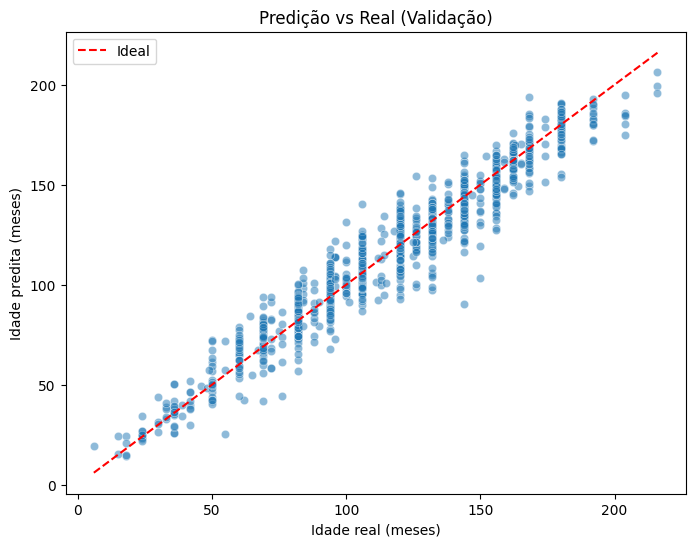

In [55]:
# =========================================================
# Avaliação Final
# =========================================================
model.load_state_dict(torch.load("/content/best_model_regression.pth"))
model.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.numpy().astype(float)
        outputs = model(imgs).cpu().numpy().flatten()
        all_labels.extend(labels)
        all_preds.extend(outputs)

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

mae_meses = mean_absolute_error(all_labels, all_preds)
rmse_meses = np.sqrt(mean_squared_error(all_labels, all_preds))
r2 = r2_score(all_labels, all_preds)

print("== Regression Report ==")
print(f"MAE  (meses): {mae_meses:.2f}  (~{mae_meses/12:.2f} anos)")
print(f"RMSE (meses): {rmse_meses:.2f}  (~{rmse_meses/12:.2f} anos)")
print(f"R²           : {r2:.3f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=all_labels, y=all_preds, alpha=0.5)
m, M = all_labels.min(), all_labels.max()
plt.plot([m, M], [m, M], 'r--', label="Ideal")
plt.xlabel("Idade real (meses)")
plt.ylabel("Idade predita (meses)")
plt.title("Predição vs Real (Validação)")
plt.legend()
plt.show()

== Regression Report ==
MAE  (meses): 8.04  (~0.67 anos)
RMSE (meses): 10.96  (~0.91 anos)
R²           : 0.916


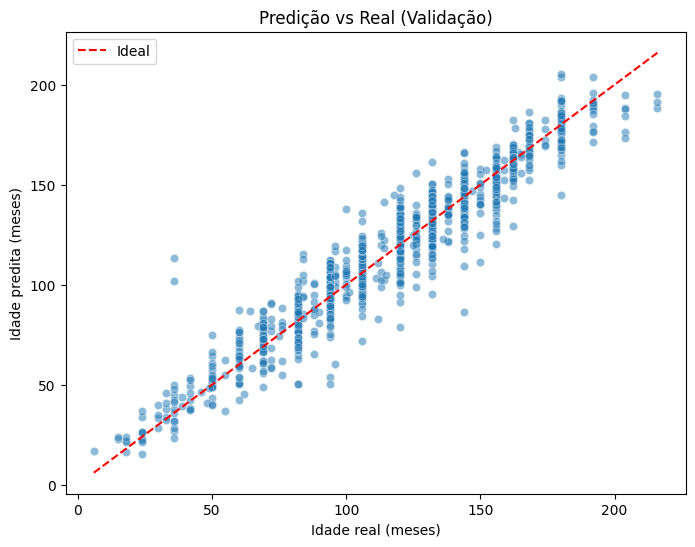

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load("/content/best_model_regression.pth"))
model.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.numpy().astype(float)     # em MESES
        outputs = model(imgs).cpu().numpy().flatten()
        all_labels.extend(labels)
        all_preds.extend(outputs)

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)

mae_meses = mean_absolute_error(all_labels, all_preds)
rmse_meses = np.sqrt(mean_squared_error(all_labels, all_preds))
r2 = r2_score(all_labels, all_preds)

print("== Regression Report ==")
print(f"MAE  (meses): {mae_meses:.2f}  (~{mae_meses/12:.2f} anos)")
print(f"RMSE (meses): {rmse_meses:.2f}  (~{rmse_meses/12:.2f} anos)")
print(f"R²           : {r2:.3f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=all_labels, y=all_preds, alpha=0.5)
m, M = all_labels.min(), all_labels.max()
plt.plot([m, M], [m, M], 'r--', label="Ideal")
plt.xlabel("Idade real (meses)")
plt.ylabel("Idade predita (meses)")
plt.title("Predição vs Real (Validação)")
plt.legend()
plt.show()



In [47]:
import torch, gc

def free_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print(">> Memória da GPU liberada!")
free_gpu_memory()

>> Memória da GPU liberada!
